In [1]:
%load_ext autoreload
import sys
sys.path.append('../')

import pandas as pd
from faces_clustering import VideoClustering

Using TensorFlow backend.


In [2]:
video_clustering = VideoClustering('senet50', 'agglomerative', verbose=2)

### Clustering Video Faces Using Its Frames

Processing D:/Movies/360Video/omelete.mp4
extracting frames
Original video fps is 30. Extracting at each 300.0 frames
extracting embeddings



clustering


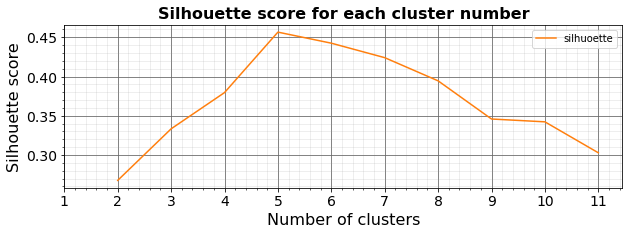

Best cluster number is 5


In [3]:
res = video_clustering.cluster("D:/Movies/360Video/omelete.mp4", fps=0.1)

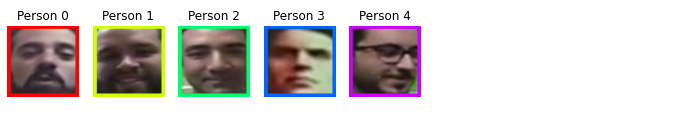

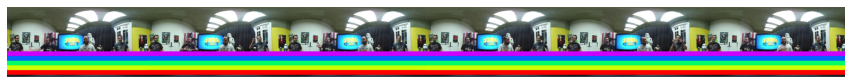

In [4]:
video_clustering.display_timeline(limit = 10, lines = True)